In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import glob
import matplotlib.pyplot as plt
import pickle
import sys

%matplotlib inline

debugging_mode = 0

## Pipeline and Perspective warp

In [2]:
def pipeline(img, s_thresh=(100, 255), sx_thresh=(120, 255)):
    img = undistort(img)
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 1) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

def perspective_warp(img, 
                     dst_size=(1280,720),
                     src=np.float32([(0.38,0.7),(0.63,0.7),(0.1,1),(1,1)]),
                     dst=np.float32([(0,0), (1, 0), (0,1), (1,1)])):
    """
    Function that generates perspective warp for a given img.

    :param img: input image 
    :param dst_size: output size 
    :param src: warping points in the source image
    :param dst: warping point in the dst image
    :return: returns the perspective warped image
    """ 
    # getting image size
    img_size = np.float32([(img.shape[1],img.shape[0])])
    # mapping warping points in the source image
    src = src* img_size
    # mapping warping points in the destination image
    dst = dst * np.float32(dst_size)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, dst_size)
    return warped

def inv_perspective_warp(img, 
                     dst_size=(1280,720),
                     src=np.float32([(0,0), (1, 0), (0,1), (1,1)]),
                     dst=np.float32([(0.38,0.7),(0.63,0.7),(0.1,1),(1,1)])):
    """
    Function that generates inverse perspective warp for a given img.

    :param img: input image 
    :param dst_size: output size 
    :param src: warping points in the source image
    :param dst: warping point in the dst image
    :return: returns the inverse perspective warped image
    """ 
    # getting image size 
    img_size = np.float32([(img.shape[1],img.shape[0])])
    # mapping warping points in the source image
    src = src * img_size    
    # mapping warping points in the destination image
    dst = dst * np.float32(dst_size)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, dst_size)
    return warped


def get_hist(img):
    """
    Function that generates histogram for a given img.

    :param img: input image 
    :return: returns the histogram of the image
    """ 
    # getting the histogram of the image by summing all points in the lower half the image
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    return hist



In [7]:
def abs_sobel_thresh(gray, orient='x', thresh=(0, 255)):
    """
    Function that generates absolute sobel threshold for a given gray img.

    :param gray: input image 
    :param orient: orientation of the gradient
    :param thresh: min and max threshold values    
    :return: returns the absolute sobel thresholded image
    """ 
    # Apply x gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # create a zero numpy array with the same size as scaled_sobel
    binary_output = np.zeros_like(scaled_sobel)
    # apply threshold
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the result
    sobel_mask = binary_output
    return sobel_mask


def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Function that generates direction threshold for a given gray img.

    :param gray: input image 
    :param sobel_kernel: kernel size
    :param thresh: min and max threshold values    
    :return: returns the direction thresholded image
    """ 
    # Apply x gradient with the OpenCV Sobel() function
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    # Apply y gradient with the OpenCV Sobel() function
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # Create an empty numpy array with the same size as absgraddir
    binary_output =  np.zeros_like(absgraddir)
    # apply a threshold
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    dir_mask = binary_output
    return dir_mask


def combine_thresh(img, s_thresh=(100, 255), l_thresh=(120, 255)):
    """
    Function that generates combined threshold for a given img.

    :param img: input image 
    :param s_thresh: min and max threshold values for the s channel
    :param l_thresh: min and max threshold values for the l channel
    :return: returns the combined thresholded image
    """ 
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Getting image size
    height, width = gray.shape
    
    # Apply absolute sobel threshold for the x gradient 
    grad_x = abs_sobel_thresh(gray, 'x', thresh=(10, 200))
    # Apply direction sobel threshold for the x and y gradients
    dir_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    # Combining input from the two thresholds
    combined = ((grad_x == 1) & (dir_binary == 1))
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    # Creating an all zeros numpy array with the same size as the R channel
    color_combined = np.zeros_like(R)
    # Apply thresholds to the R and G channel
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    # Convert from rgb to hls color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Getting the S channel    
    s_channel = hls[:,:,2] 
    # Getting the L channel
    l_channel = hls[:,:,1]
    # Apply thresholds to the S channel 
    s_condition = (s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])
    
    # Apply thresholds to the L channel
    l_condition = (l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])
    
    # Combine the two thresholds
    color_combined[(r_g_condition & l_condition) & (s_condition | combined)] = 1
    
    # Create an all zeros numpy arrays with the same size as the image
    mask = np.zeros_like(color_combined)
    # Setting the region of interest
    region_of_interest_vertices = np.array([[220,height-1], [width/2, int(0.55*height)], [width-80, height-1]], dtype=np.int32)
    # Apply the region of interest
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)

    return thresholded



Text(0.5, 1.0, 'Warped Image')

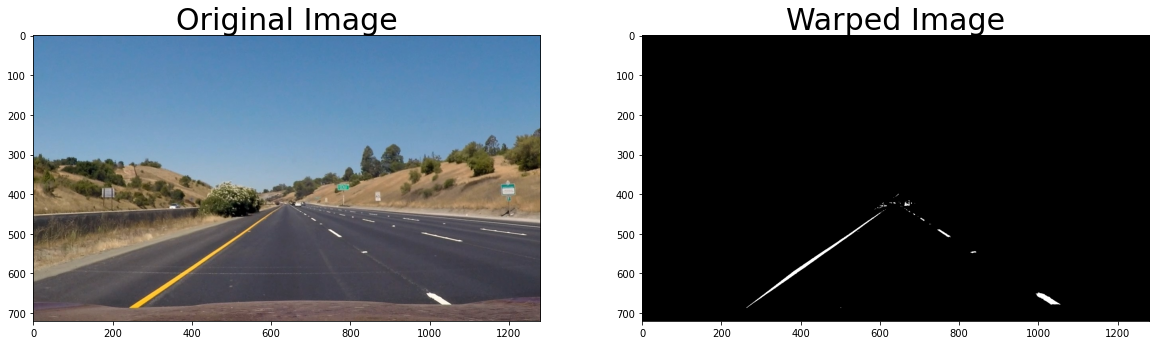

In [4]:
img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = combine_thresh(img)
# dst = perspective_warp(dst, dst_size=(1280,720))

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img, cmap="gray")
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Warped Image', fontsize=30)

## Sliding Window Algorithm and Curve Plotting

In [5]:
left_a, left_b, left_c = [],[],[]
right_a, right_b, right_c = [],[],[]

def sliding_window(img, nwindows=9, margin=150, minpix = 1, draw_windows=True):
    """
    Function that generates a sliding window for a given img.

    :param img: input image 
    :param nwindows: number of windows
    :param margin: margin for the windows (half the width of a single window) 
    :param minipix: minimum number of pixels for a window to be considered
    :param draw_windows: boolean to draw the windows  
    :return: returns out_img, and the left and right lane lines
    """ 
    global left_a, left_b, left_c,right_a, right_b, right_c 
    left_fit_= np.empty(3)
    right_fit_ = np.empty(3)
    # Creating a three channel to apply the sliding window
    out_img = np.dstack((img, img, img))*255

    # Getting the histogram of the image
    histogram = get_hist(img)
    # find peaks of leftmost and rightmost quarters 
    quarters = int(histogram.shape[0]/4)
    leftx_base = np.argmax(histogram[:quarters])
    rightx_base = np.argmax(histogram[quarters*3:]) + quarters*3
    
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if draw_windows == True:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (100,255,255), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (100,255,255), 3) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        
        if len(good_right_inds) > minpix: 
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
        
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # if the number of indices is within a certain threshold, fit a second order polynomial to each
    if(left_lane_inds.size > 2000 and right_lane_inds.size > 2000):
        # Fit a second order polynomial
        left_fit = np.polyfit(lefty, leftx, 2)  
        # store coefficients
        left_a.append(left_fit[0])
        left_b.append(left_fit[1])
        left_c.append(left_fit[2])

        # Fit a second order polynomial
        right_fit = np.polyfit(righty, rightx, 2)   
        # store coefficients
        right_a.append(right_fit[0])
        right_b.append(right_fit[1])
        right_c.append(right_fit[2])
    else:
        # if the number of indices is not within a certain threshold, use the previous coefficients
        left_a.append(left_a[-15])
        left_b.append(left_b[-15])
        left_c.append(left_c[-15])
        
        right_a.append(right_a[-15])
        right_b.append(right_b[-15])
        right_c.append(right_c[-15])
        
    # Getting the average of the pervious 10 coefficients
    left_fit_[0] = np.mean(left_a[-10:])
    left_fit_[1] = np.mean(left_b[-10:])
    left_fit_[2] = np.mean(left_c[-10:])
    
    right_fit_[0] = np.mean(right_a[-10:])
    right_fit_[1] = np.mean(right_b[-10:])
    right_fit_[2] = np.mean(right_c[-10:])
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit_[0]*ploty**2 + left_fit_[1]*ploty + left_fit_[2]
    right_fitx = right_fit_[0]*ploty**2 + right_fit_[1]*ploty + right_fit_[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 100]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 100, 255]
    
    return out_img, (left_fitx, right_fitx), (left_fit_, right_fit_), ploty

def get_curve(img, leftx, rightx):
    """
    Calculate the radius of curvature in meters for both lane lines

    :param img: input image 
    :param leftx: x-values of the left lane line pixels
    :param rightx: x-values of the right lane line pixels    
    :return: radius of curvature of left and right lane lines in meters, and the offset of the vehicle from the center of the lane
    """ 
    # Define conversions in x and y from pixels space to meters
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    y_eval = np.max(ploty)
    ym_per_pix = 30.5/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/720 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # getting the offset of the vehicle from the center of the lane
    car_pos = img.shape[1]/2
    l_fit_x_int = left_fit_cr[0]*img.shape[0]**2 + left_fit_cr[1]*img.shape[0] + left_fit_cr[2]
    r_fit_x_int = right_fit_cr[0]*img.shape[0]**2 + right_fit_cr[1]*img.shape[0] + right_fit_cr[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center = (car_pos - lane_center_position) * xm_per_pix / 10
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad, center)

def draw_lanes(img, left_fit, right_fit):
    """
    Draw the detected lane lines on the input image

    :param img: input image 
    :param left_fit: coefficients of the left lane line polynomial
    :param right_fit: coefficients of the right lane line polynomial    
    :return: returns the image with the lane lines drawn on it
    """ 
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    color_img = np.zeros_like(img)
    
    left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    points = np.hstack((left, right))
   
    cv2.fillPoly(color_img, np.int_(points), (100,200,255))
    inv_perspective = inv_perspective_warp(color_img)
    inv_perspective = cv2.addWeighted(img, 1, inv_perspective, 0.7, 0)
    return inv_perspective


In [6]:
#%matplotlib gtk
out_img, curves, lanes, ploty = sliding_window(dst)
plt.imshow(dst)
plt.plot(curves[0], ploty, color='yellow', linewidth=3)
plt.plot(curves[1], ploty, color='yellow', linewidth=3)
# print(np.asarray(curves).shape)
curverad=get_curve(img, curves[0],curves[1])
# print(curverad)
img_ = draw_lanes(img, curves[0], curves[1])
plt.imshow(out_img, cmap='hsv')

C:\Users\Loay Elshall\AppData\Local\Temp\ipykernel_4164\2442092016.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  window_height = np.int(img.shape[0]/nwindows)
C:\Users\Loay Elshall\AppData\Local\Temp\ipykernel_4164\2442092016.py:68: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use

Left:  2111
Right:  666


IndexError: list index out of range

In [ ]:
def concat_tile(im_list_2d):
    return cv2.vconcat([cv2.hconcat(im_list_h) for im_list_h in im_list_2d])

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(100, 20))
#f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original', fontsize=10)
ax2.imshow(dst)
ax2.set_title('Filter+Perspective Tform', fontsize=10)
ax3.imshow(out_img)
ax3.plot(curves[0], ploty, color='yellow', linewidth=3)
ax3.plot(curves[1], ploty, color='yellow', linewidth=3)
ax3.set_title('Sliding window+Curve Fit', fontsize=10)
ax4.imshow(img_)
ax4.set_title('Overlay Lanes', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Video Pipeline

In [ ]:
def concat_tile(im_list_2d):
    return cv2.vconcat([cv2.hconcat(im_list_h) for im_list_h in im_list_2d])

def vid_pipeline(img):
    """
    Pipeline for video processing

    :param img: input image     
    :return: returns the image after the whole pipline
    """ 
    global running_avg
    global index
    img_thresh = combine_thresh(img)
    img_warp = perspective_warp(img_thresh)
    out_img, curves, lanes, ploty = sliding_window(img_warp, draw_windows=True)
    curverad = get_curve(img, curves[0], curves[1])
    lane_curve = np.mean([curverad[0], curverad[1]])
    img = draw_lanes(img, curves[0], curves[1])
    
    img_thresh = np.dstack((img_thresh, img_thresh, img_thresh))*255
    img_warp = np.dstack((img_warp, img_warp, img_warp))*255
    
    img_tile = concat_tile([[img, img_warp],
                            [out_img, img_thresh]])

    img_tile = cv2.resize(img_tile,(1280,720))
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (0, 0, 0)
    fontSize=0.5
    cv2.putText(out_img, 'Lane Curvature: {:.0f} m'.format(lane_curve), (570, 620), font, fontSize, fontColor, 2)
    cv2.putText(out_img, 'Vehicle offset: {:.4f} m'.format(curverad[2]), (570, 650), font, fontSize, fontColor, 2)
    debugging_mode = 1
    if debugging_mode == 1:
        ret_img = img_tile
    else:
        ret_img = img
    return ret_img

In [ ]:
right_curves, left_curves = [],[]
from moviepy.editor import VideoFileClip

myclip = VideoFileClip('challenge_video.mp4')#.subclip(0,9)
output_vid = 'output_after_commenting.mp4'
clip = myclip.fl_image(vid_pipeline)
clip.write_videofile(output_vid, audio=False)